<a href="https://colab.research.google.com/github/isabelklint/final_oa/blob/main/final_oa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color="palegreen">NLP Project for Open Avenues Micro-Internship

In [1]:
# install required packages if necessary
# !pip install spacy
# !pip install gensim
# !pip install pyldavis
# !pip install wordcloud
# !pip install pyLDAvis

In [121]:
# import statements
import en_core_web_sm
import gensim
import io
import itertools
import math
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
import random
import re
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.models import Word2Vec
from google.colab import files
from IPython.core.display import display
from itertools import product
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import spacy
from spacy.lang.en import English
import string
import warnings
import wordcloud
import warnings

# Suppress warnings (not recommended)
warnings.filterwarnings('ignore')


In [3]:
# choose file from your computer: open_ave_data.csv
uploaded = files.upload()


Saving open_ave_data.csv to open_ave_data (1).csv


In [122]:
# take a look temp stats
temp = pd.read_csv('open_ave_data.csv', index_col=0)


In [123]:
# remove duplicates
df = temp.drop_duplicates()


In [124]:
# drop null values
df.dropna(inplace=True)


In [125]:
# take a look at df stats
df.describe()


,ReportText,findings,clinicaldata,ExamName,impression
count,950,950,950,950,950
unique,950,406,367,732,486
top,EXAM: CHEST RADIOGRAPHY EXAM DATE: 06/01/2019 ...,FINDINGS: Lungs/Pleura: No focal opacities evi...,CLINICAL HISTORY: Chest pain. \n\n,EXAM: CHEST 2 VIEW\n\nCOMPARISON: None.,IMPRESSION: Normal single view chest.
freq,1,174,84,35,160


In [126]:
# different look at df stats
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 0 to 986
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ReportText    950 non-null    object
 1   findings      950 non-null    object
 2   clinicaldata  950 non-null    object
 3   ExamName      950 non-null    object
 4   impression    950 non-null    object
dtypes: object(5)
memory usage: 44.5+ KB


In [127]:
# rename ExamName to examname so it matches other headings
df.rename(columns={'ExamName': 'examname'}, inplace=True)


In [128]:
# make df lowercase
df = df.applymap(lambda x: x.lower() if type(x) == str else x)


In [129]:
# look at df to see changes
df.head(2)


,ReportText,findings,clinicaldata,examname,impression
0,exam: chest radiography exam date: 06/01/2019 ...,findings: lungs/pleura: no focal opacities evi...,clinical history: cough. \n\n,exam: chest radiography exam date: 06/01/2019 ...,impression: normal 2-view chest radiography.
1,exam: chest radiography exam date: 05/23/2020 ...,findings: lungs/pleura: no focal opacities evi...,clinical history: chest pain. \n\n,exam: chest radiography exam date: 05/23/2020 ...,impression: no acute cardiopulmonary abnormali...


In [130]:
# remove heading text from last four columns respectively
text_columns = ['findings', 'clinicaldata', 'examname', 'impression']
remove_words = [['findings'], ['clinical history', 'clinical information', 'clinical indications', 'history', 'clinical indication'], ['examination', 'exam'], ['impression']]
for col, words in zip(text_columns, remove_words):
    for word in words:
        df[col] = df[col].str.replace(word, '', case=False)


In [131]:
# remove stop words, punctuation, and numbers from df
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
text_columns = ['ReportText', 'findings', 'clinicaldata', 'examname', 'impression']
for col in text_columns:
    df[col] = df[col].apply(lambda x: ' '.join([word for word in re.findall(r'\b\w+\b', x)
    if word.lower() not in stop_words and not all(char in punctuation or char.isdigit() for char in word)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
df.head(2)

,ReportText,findings,clinicaldata,examname,impression
0,exam chest radiography exam date pm clinical h...,lungs pleura focal opacities evident pleural e...,cough,chest radiography date pm technique views comp...,normal view chest radiography
1,exam chest radiography exam date pm clinical h...,lungs pleura focal opacities evident pleural e...,chest pain,chest radiography date pm technique view compa...,acute cardiopulmonary abnormality


In [133]:
# make a df_original from cleaned and processed df to re-use 
df_original = df


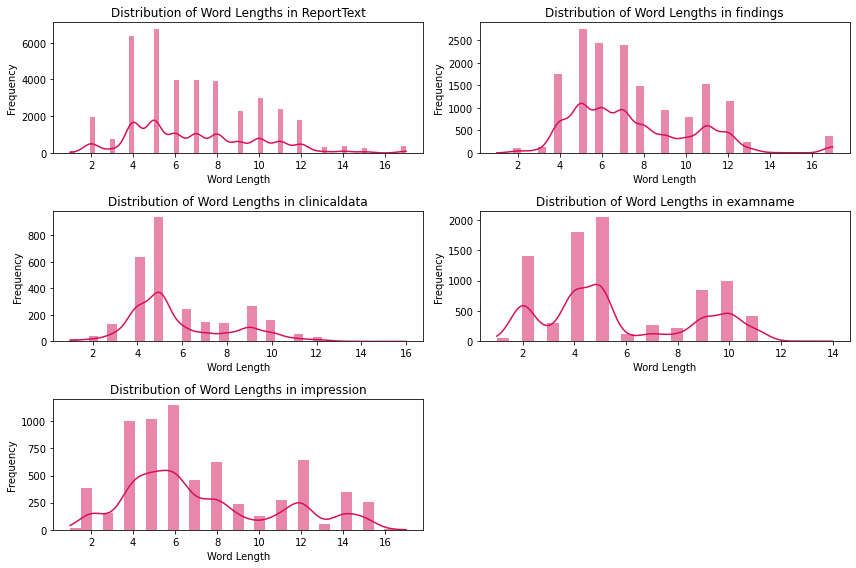

In [134]:
# text stats:  distribution of word lengths
text_columns = ['ReportText', 'findings', 'clinicaldata', 'examname', 'impression']
# nmber of columns in the grid
num_cols = 2
# number of rows in the grid
num_rows = math.ceil(len(text_columns) / num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, col in enumerate(text_columns):
    data = " ".join(review for review in df[col])
    word_lengths = [len(word) for word in data.split()]
    # row index in the grid
    row_idx = i // num_cols
    # column index in the grid
    col_idx = i % num_cols  
    # subplot axes
    ax = axes[row_idx][col_idx] if num_rows > 1 else axes[col_idx]
    sns.histplot(word_lengths, kde=True, color='#D41159', edgecolor='none', ax=ax)
    ax.set_title(f'Distribution of Word Lengths in {col}')
    ax.set_xlabel('Word Length')
    ax.set_ylabel('Frequency')

# remove unused subplots
if num_rows * num_cols > len(text_columns):
    for i in range(len(text_columns), num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx][col_idx])

# sdjust the spacing between subplots
plt.tight_layout()  
plt.show()


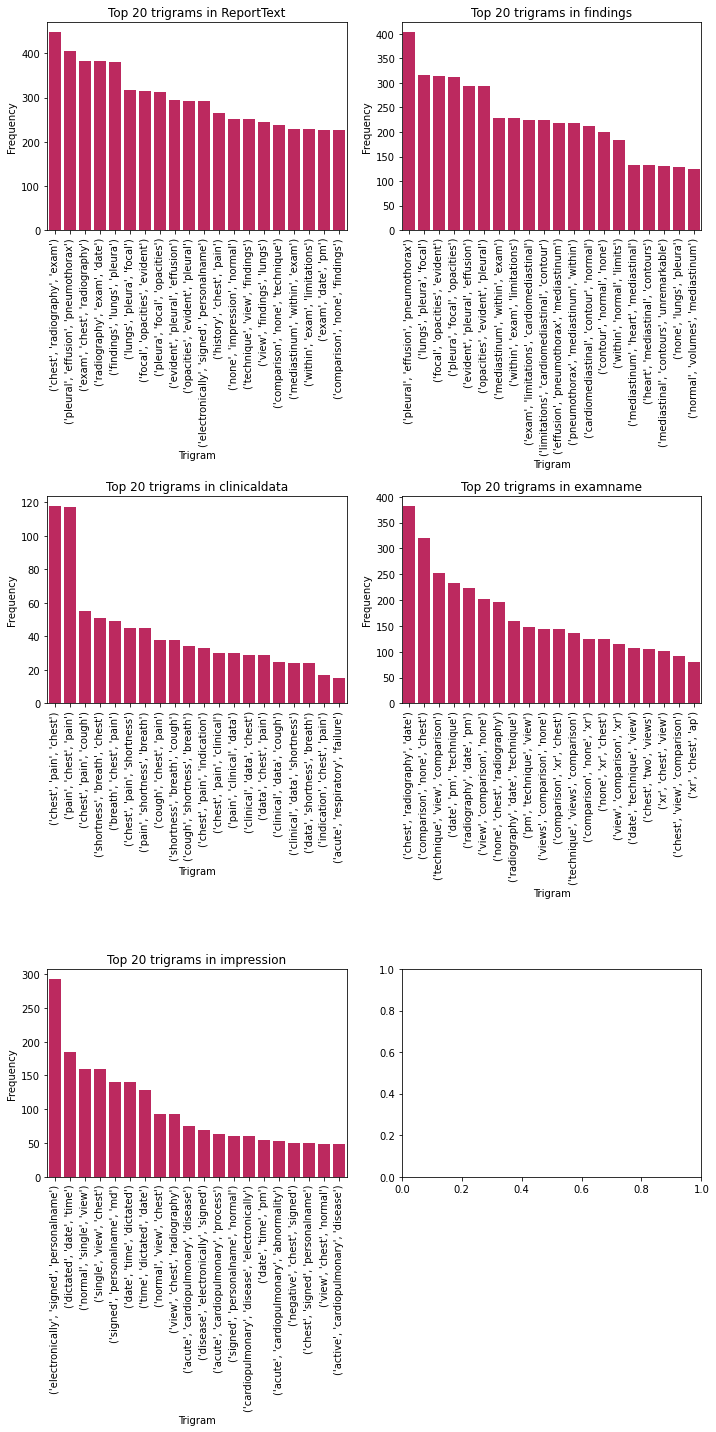

In [135]:
# visualise most frequent tri-grams in text in a grid
text_columns = ['ReportText', 'findings', 'clinicaldata', 'examname', 'impression']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 20))
fig.tight_layout(pad=20.0)

for i, col in enumerate(text_columns):
    data = " ".join(field for field in df[col])
    words = data.split()
    trigrams = ngrams(words, 3)
    ngrams_count = Counter(trigrams)
    top_ngrams = ngrams_count.most_common(20)
    top_ngrams_df = pd.DataFrame(top_ngrams, columns=['n-gram', 'frequency'])
    
    row = i // 2
    col = i % 2
    sns.barplot(ax=axes[row][col], x='n-gram', y='frequency', data=top_ngrams_df, color='#D41159')
    # axes[row][col].set_title(f'Top 20 trigrams in {col}')
    axes[row][col].set_title(f'Top 20 trigrams in {text_columns[i]}')
    axes[row][col].set_xlabel('Trigram')
    axes[row][col].set_ylabel('Frequency')
    axes[row][col].set_xticklabels(top_ngrams_df['n-gram'], rotation=90)

plt.tight_layout()
plt.show()


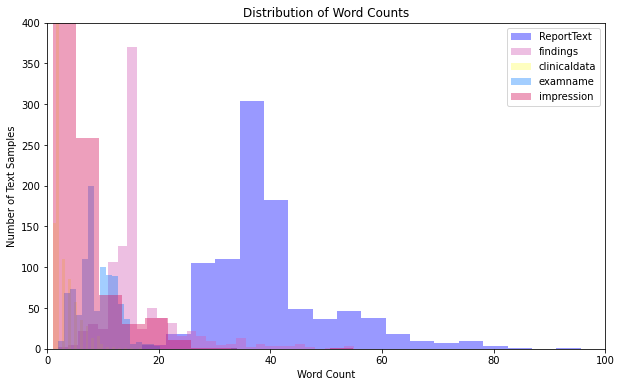

In [136]:
# visualise word count of each field
text_columns = ['ReportText', 'findings', 'clinicaldata', 'examname', 'impression']

# Define colors for each label
colours = {'findings': '#D35FB7', 'clinicaldata': '#FEFE62', 'examname': '#1A85FF', 'impression': '#D41159'}

plt.figure(figsize=(10, 6))

for col in text_columns:
    word_counts = df[col].apply(lambda x: len(x.split()))
    count_freq = Counter(word_counts)
    
    # Set the color of the bars for this label
    color = colours.get(col, 'blue')
    
    plt.hist(word_counts, alpha=0.4, label=col, bins=30, color=color)

plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Text Samples')
plt.xlim([0, 100])
plt.ylim([0, 400])
plt.legend()
plt.show()


In [137]:
# # get spacy english language model and nltk libraries for text pre-processing
# spacy.load('en_core_web_sm')
# from spacy.lang.en import English
# parser = English()
# import nltk
# nltk.download('wordnet')
# from nltk.corpus import wordnet as wn

def get_lemma(word):
  # use wordnet, lemmatisation
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
        
from nltk.stem.wordnet import WordNetLemmatizer

def get_lemma2(word):
  # use wordnet, stemming
    return WordNetLemmatizer().lemmatize(word)
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
# make everything lowercase
df = temp.applymap(lambda x: x.lower() if type(x) == str else x)


In [139]:
# define regular expression pattern to remove numbers and punctuation
pattern = r'[^\w\s]|\d+'

# define function to clean text
def clean_text(text):
    if pd.isna(text):
        return ''
    # remove newlines
    text = text.replace('\n', ' ')
    # apply regular expression pattern to remove numbers and punctuation
    text = re.sub(pattern, '', text)
    return text

# clean the whole df
df_clean = df.applymap(clean_text)


In [ ]:
# running this cell will take a long time
# load spacy model
nlp = en_core_web_sm.load()

df_clean = df_clean.dropna()
df_clean = df_clean.reset_index(drop=True)

# tokenize text
def tokenize(text):
    lda_tokens = []
    tokens = nlp(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# lemmatize tokens
def get_lemma(token):
    return token.lemma_

def prepare_text_for_lda(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_stop and token.text not in string.punctuation]
    tokens = [token for token in tokens if len(token) > 4 and not token.lower() in ['findings', 'clinical', 'history', 'exam', 'impression']]
    tokens = [get_lemma(nlp(token)[0]) for token in tokens]
    return tokens

# create corpus and dictionary
report_text_data = df_clean['ReportText'].tolist()
text_data = [prepare_text_for_lda(text) for text in report_text_data]
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

# train LDA model (this takes a long time)
NUM_TOPICS = 4
ldamodel = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model4.gensim')

# visualize LDA model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
display(vis)


In [ ]:
# running this cell will take a long time
# make word clouds and compare them to topics: 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS
import numpy as np

# create a custom colormap with shades of pink and reds
colors = ["#f5d5d5", "#f5b8b8", "#f68c8c", "#f56868", "#f54242", "#f51818"]
cmap = ListedColormap(colors)

def display_wordcloud(text):
    stopwords = set(STOPWORDS)
    # wc = WordCloud(stopwords=stopwords, background_color='white', width=1000, height=300, colormap=cmap, max_words=10)
    wc = WordCloud(stopwords=stopwords, background_color='white', width=1000, height=300, colormap=cmap, max_words=15, collocations=False)
    wc.generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

for col in ['examname', 'findings', 'clinicaldata', 'impression']:
    # text = ' '.join([str(x) + ' ' for x in df_clean[col].fillna('').str.split().tolist()])
    # text = ' '.join([str(x).strip() + ' ' for x in df_clean[col].fillna('').str.split().tolist()])
    text = ' '.join([str(x).replace("'", "") + ' ' for x in df_original[col].fillna('').str.split().tolist()])
    display_wordcloud(text)
    for i, row in enumerate(ldamodel[dictionary.doc2bow(prepare_text_for_lda(text))]):
        if i >= 10:
            break
        topic_num = row[0]
        topic_words = ldamodel.show_topic(topic_num, 4)
        topic_words = ', '.join([word[0] for word in topic_words])
        similarity = row[1]
        print(f'{col} - Topic {topic_num}, Similarity: {similarity:.2f}, Words: {topic_words}')


In [ ]:
# get original df
data = df_original.drop('ReportText', axis=1)


In [ ]:
# convert all strings to lowercase
data = data.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)


In [ ]:
# take a quick look
data.head(2)


In [ ]:
# melt dataframe
df_melted = pd.melt(data, var_name='label', value_name='text')
# display melted dataframe
print(df_melted)


In [ ]:
# get rid of null values
df = df_melted.dropna(subset=['text'])


#<font color="palegreen">TF-IDF word embedding visualization
TF-IDF word embedding for key words: 'exam', 'findings', 'clinical', and 'impression'.

Given a 2-column df of labels and texts:
*   Print top 20 most important features per label.
*   Get list of labels from label column. 
*   Make TD-IDF embeddings using TdidfVectorizer from scikit-learn.
*   Dimensionality reduction via t-SNE from scikit-learn.
*   Create scatterplot: x and y correspond to the t-SNE generated 2D array, colours correspond to labels.

In [ ]:
# create a list of unique labels
labels = df['label'].unique()

# generate tf-idf embeddings
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['text'])

# train a logistic regression model
lr = LogisticRegression()
lr.fit(tfidf_matrix, df['label'])

# # get the top 20 most important features for each label
# for i, label in enumerate(labels):
#     feature_names = vectorizer.get_feature_names_out()
#     coef = lr.coef_[i]
#     top_features = sorted(zip(coef, feature_names), reverse=True)[:20]
#     print(f'Top 20 most important features for {label}:')
#     for feature in top_features:
#         print(f'{feature[1]} ({feature[0]:.2f})')
#     print()

# apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# create a scatter plot with color coded sections
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    color = plt.cm.rainbow(np.linspace(0, 1, len(labels)))[i]
    indices = df['label'] == label
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=color, label=label, alpha=0.5)
plt.legend()
plt.show()


#<font color="palegreen">Train and Evaluate a logistic regression classifier for field extraction. 
*   Split df into training and testing datasets.
*   Transform the text data via TD-IDF vectoriser to a numerical feature matrix.
*   Fit the vectorizer on the training data.
*   Train the classifier on the training data
*   Predict labels for the testing data
*   Print the accuracy score, confusion matrix, and classification report.

In [ ]:
# Load the data into a DataFrame
data = df

# Split the data into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
vectorizer.fit(train_data['text'])

# Transform the text data into a numerical feature matrix
train_features = vectorizer.transform(train_data['text'])
test_features = vectorizer.transform(test_data['text'])

# Create the logistic regression classifier
classifier = LogisticRegression(C=1, solver='saga')

# Train the classifier on the training data
classifier.fit(train_features, train_data['label'])

# Predict labels for the testing data
predictions = classifier.predict(test_features)

# Print the accuracy score
accuracy = accuracy_score(test_data['label'], predictions)
print("Accuracy:", accuracy)

# Print the confusion matrix
cm = confusion_matrix(test_data['label'], predictions)
print("Confusion Matrix:\n", cm)

# Print the classification report
cr = classification_report(test_data['label'], predictions)
print("Classification Report:\n", cr)


#<font color="palegreen">Confusion matrix heatmap.
Confusion matrix compares predicted/true labels of a machine learning classifier (logistic regression).

In [ ]:
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set the x-axis labels
plt.xticks([0.5, 1.5, 2.5, 3.5], ['findings', 'clinicaldata', 'examname', 'impression'])

# Set the y-axis labels
plt.yticks([0.5, 1.5, 2.5, 3.5], ['findings', 'clinicaldata', 'examname', 'impression'])

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# take a quick look at df
df_melted.head(2)


In [ ]:
# Load stop words
stop_words = stopwords.words('english')

# Tokenize sentences into lists of words
sentences = [s.split() for s in df_original['ReportText']]

# Load word2vec model
model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)


In [ ]:
# use pretrained model to get word embedding for each word in text
nltk.download('punkt')

# Tokenize the text in df_melted
df_melted['tokenized_text'] = df_melted['text'].apply(nltk.word_tokenize)

# Extract the embeddings
embeddings = []
out_of_vocab = []
for word_list in df_melted['tokenized_text'].values:
    for word in word_list:
        if word in model.wv:
            embeddings.append(model.wv[word])
        else:
            out_of_vocab.append(word)
            
if len(out_of_vocab) > 0:
    print(f"Ignoring {len(out_of_vocab)} out-of-vocabulary words: {', '.join(out_of_vocab)}")
    
embeddings = np.array(embeddings)


#<font color="palegreen">Word2Vec word embedding visualization
Word2Vec word embedding for 'exam', 'findings', 'clinical', and 'impression'.

*   Get words similar to above words from a pre-trained word embedding model using Gensim library. 
*   Cluster embeddings of similar words, store them in 2D numpy array.
*   Reduce  dimensionality of  embeddings from 3D numpy array to 2D via Scikit-learn t-SNE algorithm.
*   Plots the 2D embeddings of each word/similar words with Matplotlib. Points correspond to single words in the embedding space.

In [ ]:
keys = ['exam', 'findings', 'clinical', 'impression']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=np.array([color]), alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words('Similar words from Report Text', keys, embeddings_en_2d, word_clusters, 0.7)


#<font color="palegreen">Word2Vec sentence embedding visualization
Word2Vec word embedding for 'exam', 'findings', 'clinical', and 'impression'.

*   Tokenise sentences into lists of words. 
*   Get word2vec model using tokenised sentences and get create sentence embeddings (mean value of word embeddings), store them in a list of numpy arrays.
*   Make list into 2d array (rows are sentence embeddings, columns are dimensions) using np.vstack()
*   Reduce dimensionality of the sentence embeddings to 2D via t-SNE.
*   Plot sentence embeddings in 2D space, points correspond to sentence embeddings and point colour corresponds to sentence labels.

In [ ]:
# Load stop words
stop_words = stopwords.words('english')

# Tokenize sentences into lists of words
sentences = [s.split() for s in df_original['ReportText']]

# Load word2vec model
model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

# Create sentence embeddings
sentence_embeddings = []
labels = df_melted['label']
for sentence, label in zip(df_melted['text'], labels):
    words = sentence.split()
    words = [word for word in words if word not in stop_words]
    word_embeddings = []
    for word in words:
        if word in model.wv.key_to_index:
            word_embeddings.append(model.wv[word])
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
        sentence_embeddings.append(sentence_embedding)

# Stack sentence embeddings into 2D array
sentence_embeddings = np.vstack(sentence_embeddings)

# Apply t-SNE to sentence embeddings
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = tsne_model_en_2d.fit_transform(sentence_embeddings)

# Plot sentence embeddings
plt.figure(figsize=(16, 9))
labels = np.unique(df_melted['label'])
colours = {'findings': '#D35FB7', 'clinicaldata': '#FEFE62', 'examname': '#1A85FF', 'impression': '#D41159'}
for label in labels:
    indices = np.where(df_melted['label'] == label)
    plt.scatter(embeddings_en_2d[indices, 0], embeddings_en_2d[indices, 1], c=colours[label], label=label)
plt.title('Sentence Embeddings')
plt.legend()
plt.show()

In [ ]:
text_columns = ['ReportText', 'findings', 'clinicaldata', 'examname', 'impression']

# Define colors for each label
colours = {'findings': '#D35FB7', 'clinicaldata': '#FEFE62', 'examname': '#1A85FF', 'impression': '#D41159'}

plt.figure(figsize=(10, 6))

for col in text_columns:
    word_counts = df_original[col].apply(lambda x: len(x.split()))
    count_freq = Counter(word_counts)
    
    # Set the color of the bars for this label
    color = colours.get(col, 'blue')
    
    plt.hist(word_counts, alpha=0.3, label=col, bins=30, color=color)

plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Text Samples')
plt.xlim([0, 100])
plt.ylim([0, 400])
plt.legend()
plt.show()


#<font color="palegreen">Classification reports for Word2vec and TF-IDF models
This code generates classification reports for two different models: Word2Vec and TF-IDF.

In [ ]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute the TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df_melted['text'])

# Train a logistic regression model with Word2Vec vectors
sentences = [s.split() for s in df_melted['text']]
X = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
y = df_melted['label']
lr_w2v = LogisticRegression(random_state=42, max_iter=10000)
lr_w2v.fit(X, y)

# Train a logistic regression model with TF-IDF vectors
lr_tfidf = LogisticRegression(random_state=42)
lr_tfidf.fit(tfidf_vectors, y)

# Compute the accuracies of both models on the training set
X_test = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
tfidf_vectors_test = tfidf_vectorizer.transform(df_melted['text'])
y_pred_w2v = lr_w2v.predict(X_test)
y_pred_tfidf = lr_tfidf.predict(tfidf_vectors_test)
accuracy_w2v = accuracy_score(y, y_pred_w2v)
accuracy_tfidf = accuracy_score(y, y_pred_tfidf)


# Generate classification report for Word2Vec model
print('Classification report for Word2Vec model:')
print(classification_report(y, y_pred_w2v))

# Generate classification report for TF-IDF model
print('Classification report for TF-IDF model:')
print(classification_report(y, y_pred_tfidf))


In [ ]:
# Import StandardScaler from scikit-learn
from sklearn.preprocessing import StandardScaler

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute the TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df_melted['text'])

# Train a logistic regression model with Word2Vec vectors
sentences = [s.split() for s in df_melted['text']]
X = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
y = df_melted['label']

# Scale the Word2Vec vectors using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# add solver to remove error
lr_w2v = LogisticRegression(random_state=42, solver='liblinear')
lr_w2v.fit(X_scaled, y)

# Train a logistic regression model with TF-IDF vectors
lr_tfidf = LogisticRegression(random_state=42)
lr_tfidf.fit(tfidf_vectors, y)

# Compute the accuracies of both models on the training set
X_test = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
tfidf_vectors_test = tfidf_vectorizer.transform(df_melted['text'])

# Scale the Word2Vec test vectors using StandardScaler
X_test_scaled = scaler.transform(X_test)

y_pred_w2v = lr_w2v.predict(X_test_scaled)
y_pred_tfidf = lr_tfidf.predict(tfidf_vectors_test)
accuracy_w2v = accuracy_score(y, y_pred_w2v)
accuracy_tfidf = accuracy_score(y, y_pred_tfidf)

# Generate classification report for Word2Vec model
print('Classification report for Word2Vec model:')
print(classification_report(y, y_pred_w2v))

# Generate classification report for TF-IDF model
print('Classification report for TF-IDF model:')
print(classification_report(y, y_pred_tfidf))


In [ ]:
# too accurate of models, why?
# which features are the most important for each field?
# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients for the TF-IDF model
coefficients_tfidf = lr_tfidf.coef_

# Print the top 10 most important features for each label
for i, label in enumerate(lr_tfidf.classes_):
    print(f'Top 10 features for label "{label}":')
    sorted_indices = np.argsort(coefficients_tfidf[i])[::-1]
    top_features = [feature_names[j] for j in sorted_indices[:10]]
    print(', '.join(top_features))
    print()


In [ ]:
# get importance for each word above for each field
# Define the list of words to get the importance of
word_list = ['pain', 'cough', 'breath', 'shortness', 'indication', 'respiratory', 'dyspnea', 'fever', 'sob',
             'failure', 'comparison', 'chest', 'technique', 'views', 'none', 'date', 'xr', 'view', 'pa', 'ap',
             'heart', 'size', 'normal', 'pleural', 'lungs', 'silhouette', 'cardiomediastinal', 'within', 'osseous',
             'effusion', 'normal', 'personalname', 'signed', 'cardiopulmonary', 'acute', 'disease', 'single',
             'electronically', 'process', 'radiography']

# Get the index of the 'Findings' label
label_idx = np.where(lr_tfidf.classes_ == 'findings')[0][0]

# Get the top 10 features for the 'Findings' label
top_features = np.argsort(lr_tfidf.coef_[label_idx])[-10:]
features = tfidf_vectorizer.get_feature_names_out()
top_features_names = [features[i] for i in top_features]

# Define an empty dataframe to store the results
results_df = pd.DataFrame(columns=['word', 'label', 'importance'])

# Loop through the word list and get the importance for each label
for word in word_list:
    for label in lr_tfidf.classes_:
        label_idx = np.where(lr_tfidf.classes_ == label)[0][0]
        if label == 'findings':
            top_features = np.argsort(lr_tfidf.coef_[label_idx])[-10:]
        else:
            top_features = np.argsort(-lr_tfidf.coef_[label_idx])[-10:]
        features = tfidf_vectorizer.get_feature_names_out()
        if word in features:
            feature_idx = features.tolist().index(word)
            if feature_idx in top_features:
                importance = lr_tfidf.coef_[label_idx][feature_idx]
                results_df = results_df.append({'word': word, 'label': label, 'importance': importance},
                                               ignore_index=True)


In [ ]:
# melt df to show which words from above have any importance at all for each field (label)
# Create a dictionary to store the importance of each word for each label
importance_dict = {'word': [], 'label': [], 'importance': []}

# Get the top features for each label
for label in ['findings', 'clinicaldata', 'examname', 'impression']:
    label_idx = np.where(lr_tfidf.classes_ == label)[0][0]
    top_features = np.argsort(lr_tfidf.coef_[label_idx])[-10:]
    features = tfidf_vectorizer.get_feature_names_out()
    top_features_names = [features[i] for i in top_features]
    
    # Store the importance of each word for the current label in the dictionary
    for word in top_features_names:
        importance_dict['word'].append(word)
        importance_dict['label'].append(label)
        importance_dict['importance'].append(tfidf_vectors[:, features.tolist().index(word)].sum())

# Create a DataFrame from the dictionary
df = pd.DataFrame(importance_dict)

# Melt the DataFrame to get the desired format
melted_df = pd.melt(df, id_vars=['word', 'label'], value_vars=['importance'], var_name='label_importance', value_name='importance_value')

# Pivot the DataFrame to get the desired format
pivoted_df = melted_df.pivot(index='word', columns='label', values='label_importance').reset_index()

# Rename the columns
pivoted_df.columns.name = None
pivoted_df = pivoted_df.rename(columns={'findings': 'finding'})

# Print the resulting DataFrame
print(pivoted_df)


In [ ]:
# how accurate are the models?
# Compute the confusion matrices
cm_w2v = confusion_matrix(y, y_pred_w2v)
cm_tfidf = confusion_matrix(y, y_pred_tfidf)

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the gradient colors
colors = ['#FFFFFF', '#D41159']

# Create a custom color map
cmap = sns.blend_palette(colors, as_cmap=True)

# Plot confusion matrix for td-idf model
sns.heatmap(cm_tfidf, cmap=cmap, annot=True, fmt='d', ax=axs[0], cbar=False)
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[0].set_xticklabels(['', 'Findings', 'Clinical Data', 'Exam Name', 'Impression'], fontsize=14, ha='center')
axs[0].set_yticks([0, 1, 2, 3, 4])
axs[0].set_yticklabels(['', 'Findings', 'Clinical Data', 'Exam Name', 'Impression'], fontsize=14, ha='center')
axs[0].set_title('TD-IDF Model Confusion Matrix: Accuracy', fontsize=16)
# Rotate xticklabels
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
# Rotate yticklabels
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0, ha='right')

# Plot confusion matrix for Word2Vec model
sns.heatmap(cm_w2v, cmap=cmap, annot=True, fmt='d', ax=axs[1], cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6]))
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xticklabels(['', 'Findings', 'Clinical Data', 'Exam Name', 'Impression'], fontsize=14, ha='center')
axs[1].set_yticks([0, 1, 2, 3, 4])
axs[1].set_yticklabels(['', 'Findings', 'Clinical Data', 'Exam Name', 'Impression'], fontsize=14, ha='center')
axs[1].set_title('Word2Vec Model Confusion Matrix: Accuracy', fontsize=16)
# Rotate xticklabels
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
# Rotate yticklabels
axs[1].set_yticklabels(axs[0].get_yticklabels(), rotation=0, ha='right')

# Add a common x label
fig.text(0.5, -0.05, 'True Label', ha='center', fontsize=14)

# Add a common y label
fig.text(-0.05, 0.5, 'Predicted Label', va='center', rotation='vertical', fontsize=14)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)


In [ ]:
# how precise are the models?
# Define a function to calculate precision
def precision(cm):
    return np.diag(cm) / np.sum(cm, axis=0)

# Compute the confusion matrices
cm_w2v = confusion_matrix(y, y_pred_w2v)
cm_tfidf = confusion_matrix(y, y_pred_tfidf)

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Define the gradient colors
colors = ['#FFFFFF', '#E34B9F']

# Create a custom color map
cmap = sns.blend_palette(colors, as_cmap=True)

# Plot precision for td-idf model
sns.heatmap(precision(cm_tfidf).reshape(1, -1), cmap=cmap, annot=True, fmt='.2f', ax=axs[0], cbar=False)
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[0].set_xticklabels(['', 'Findings', 'Clinical Data', 'Exam Name', 'Impression'], fontsize=14, ha='center')
axs[0].set_yticks([])
axs[0].set_title('TD-IDF Model Heatmap: Precision', fontsize=16)

# Rotate xticklabels
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
# Rotate yticklabels
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0, ha='right')

# Plot precision for Word2Vec model
sns.heatmap(precision(cm_w2v).reshape(1, -1), cmap=cmap, annot=True, fmt='.2f', ax=axs[1], cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6]))
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xticklabels(['', 'Findings', 'Clinical Data', 'Exam Name', 'Impression'], fontsize=14, ha='center')
axs[1].set_yticks([])
axs[1].set_title('Word2Vec Model Heatmap: Precision', fontsize=16)

# Rotate xticklabels
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
# Rotate yticklabels
axs[1].set_yticklabels(axs[0].get_yticklabels(), rotation=0, ha='right')

# Add a common x label
fig.text(0.5, -0.05, 'Label', ha='center', fontsize=14)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)


In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot for the logistic regression model with Word2Vec vectors
sentences = [s.split() for s in df_melted['text']]
X = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv.key_to_index], axis=0) for sentence in sentences])
y = df_melted['label']
lr_w2v = LogisticRegression(random_state=42, solver='liblinear',max_iter=10000)
lr_w2v.fit(X, y)

# Map the labels to corresponding colors
colours = {'findings': '#D35FB7', 'clinicaldata': '#FEFE62', 'examname': '#1A85FF', 'impression': '#D41159'}
colors_mapped = y.map(colours)

fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(X[:,0], X[:,1], c=colors_mapped)
plt.title('Logistic Regression with Word2Vec Vectors: Field distribution in 2D based on similarity')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Create a legend based on the unique values in y
unique_labels = y.unique()
handles = []
for label in unique_labels:
    handles.append(plt.scatter([], [], c=colours[label], label=label))
    
legend = plt.legend(handles=handles, loc='lower right')
for i, label in enumerate(unique_labels):
    legend.legendHandles[i]._sizes = [30]

plt.show()


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Compute the TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(df_melted['text'])

# Reduce the dimensionality of the sparse matrix to 100 dimensions (to match the word2vec model)
# couldn't make a scatterplot without using svd
svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_vectors_2d = svd.fit_transform(tfidf_vectors)

# Transform the reduced matrix into 2 dimensions using TSNE
tsne = TSNE(n_components=2, random_state=42)
tfidf_vectors_2d = tsne.fit_transform(tfidf_vectors_2d)


In [ ]:
import matplotlib.pyplot as plt

# Define color list
colors = ['#D35FB7', '#FEFE62', '#1A85FF', '#D41159']

fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot
plt.scatter(tfidf_vectors_2d[:, 0], tfidf_vectors_2d[:, 1], c=[colors[label] for label in pd.factorize(df_melted['label'])[0]])

# Add legend
labels = pd.factorize(df_melted['label'])[1]
plt.legend(handles=[plt.scatter([],[], c=color, label=label) for label, color in zip(labels, colors)], loc='best')

# Set plot title and axis labels
plt.title('TF-IDF Vectors with t-SNE: Medical Report Field distribution in 2D based on word importance per field')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Display plot
plt.show()


Colours chosen where possible from [davidmathlogic.com](https://https://davidmathlogic.com/colorblind/#%231A85FF-%23D41159).

All code edited and formatted by [ChatGPT](https://chat.openai.com). 

In [ ]:
# get versions
# packages = [spacy, gensim, pyLDAvis, wordcloud, pyLDAvis, matplotlib, nltk]

# for package in packages:
#     print(package.__name__, package.__version__)

My versions: 
- spacy 3.5.1
- gensim 4.3.1
- pyLDAvis 3.4.0
- wordcloud 1.8.2.2
- pyLDAvis 3.4.0
- matplotlib 3.7.1
- nltk 3.8.1